In [1]:
from functools import partial
import numpy as np
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rc("animation", html="jshtml")

import seaborn as sns

from tinygp import kernels, GaussianProcess
import optax

import flax.linen as nn

import jaxopt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [2]:
def animate(X, y, history):
    fig, ax = plt.subplots(2, 1, figsize=(6, 6))

    def update(i):
        ax[0].cla(), ax[1].cla()
        ax[0].scatter(X, y, alpha=0.4)
        ax[0].scatter(history[i]["X_train"][:-1], history[i]["y_train"][:-1], label="train")
        ax[0].scatter(history[i]["X_train"][-1], history[i]["y_train"][-1], label="selected", marker='x', s=100, c='k')
        ax[0].legend()

        idx = jnp.argsort(history[i]["X_pool"].squeeze())

        ax[1].plot(history[i]["X_pool"].squeeze()[idx], history[i]['acq'].squeeze()[idx])

    anim = FuncAnimation(fig, update, range(len(history)))
    plt.close()
    return anim

def train_fn(loss_fn, init_raw_params, optimizer, num_epochs=1, lax_scan=True):
    state = optimizer.init(init_raw_params)

    # dry run
    # loss_fn(init_raw_params)

    if lax_scan:
        value_and_grad_fn = jax.value_and_grad(loss_fn)

        def step(raw_params_and_state, aux):
            raw_params, state = raw_params_and_state
            loss, grads = value_and_grad_fn(raw_params)
            updates, state = optimizer.update(grads, state)
            raw_params = optax.apply_updates(raw_params, updates)
            return (raw_params, state), (raw_params, loss)

        (raw_params, state), (raw_params_history, loss_history) = jax.lax.scan(
            f=step, init=(init_raw_params, state), xs=None, length=num_epochs
        )
    else:
        raw_params_history = []
        loss_history = []
        raw_params = init_raw_params
        grad_fn = jax.grad(loss_fn)
        for _ in range(num_epochs):
            loss = loss_fn(raw_params)
            grads = grad_fn(raw_params)
            updates, state = optimizer.update(grads, state)
            raw_params = optax.apply_updates(raw_params, updates)
            raw_params_history.append(raw_params)
            loss_history.append(loss)
        loss_history = jnp.array(loss_history)
        raw_params_history = jnp.array(raw_params_history)
    return {
        "raw_params": raw_params,
        "raw_params_history": raw_params_history,
        "loss_history": loss_history,
    }

class GP:
    def __init__(self, X, y, lengthscale=None, variance=None, noise=None, mean=None):
        self.X = X
        self.y = y
        self.lengthscale = lengthscale
        self.variance = variance
        self.noise = noise
        self.mean = mean

    def init_params(self, key):
        values = jax.random.normal(key, (4,))
        params = {}
        if self.lengthscale is not None:
            params["log_lenthscale"] = jnp.log(self.lengthscale)
        else:
            params["log_lenthscale"] = values[0]

        if self.variance is not None:
            params["log_variance"] = jnp.log(self.variance)
        else:
            params["log_variance"] = values[1]

        if self.noise is not None:
            params["log_noise"] = jnp.log(self.noise)
        else:
            params["log_noise"] = values[2]

        if self.mean is not None:
            params["mean"] = self.mean
        else:
            params["mean"] = values[3]

        return params

    def build_gp(self, params):
        lengthscale = jnp.exp(params["log_lenthscale"])
        variance = jnp.exp(params["log_variance"])
        noise = jnp.exp(params["log_noise"])
        mean = params["mean"]
        kernel_fn = variance * kernels.ExpSquared(lengthscale)
        gp = GaussianProcess(kernel_fn, self.X, diag=noise, mean=mean)
        return gp

    def loss_fn(self, params):
        gp = self.build_gp(params)
        return -gp.log_probability(self.y)

    def optimize(self, key):
        init_params = self.init_params(key)
        optimizer = jaxopt.ScipyMinimize(fun=self.loss_fn)
        result = optimizer.run(init_params)
        return result.params

    def predict(self, params, X_star):
        gp = self.build_gp(params)
        pred_gp = gp.condition(self.y, X_star, diag=jnp.exp(params['log_noise'])).gp
        return pred_gp.mean, pred_gp.variance

# Bayesian Optimization (BO)

> Find the maximum value of a function based on previous evaluations. A tradeoff between exploitation and exploration.

## When to use BO?

* When you can't take gradient with respect to the function (blackbox) but only can evaluate the function at an input.
* Each function evaluation is costly.

## Comparison between BO and active learning.

* Goal of BO: Find maximum of a function using a surrogate model.
* Goal of active learning: Get surrogate model as close as possible to the actual function.

> Note: Generally Gaussian processes are used as a surrogate models in BO.

## Acquisition Functions

* Functions that help us achieve the goal of BO

### Upper Confidence Bound (UCB)

$$
a(x;\lambda) = \mu(x) + \lambda \sigma (x)
$$

((100, 1), (100,))

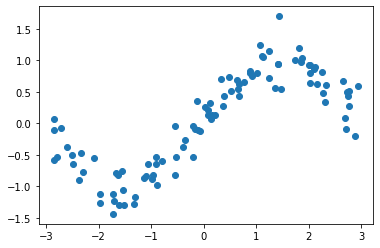

In [3]:
seed = jax.random.PRNGKey(0)
seed2 = jax.random.PRNGKey(2)
N = 100

X = jax.random.uniform(seed, shape=(N,), minval=-3, maxval=3).reshape(-1, 1)
X = jnp.sort(X, axis=0)
y = jnp.sin(X) + jax.random.normal(seed2, X.shape)*0.25
y = y.ravel()

plt.scatter(X, y);
X.shape, y.shape

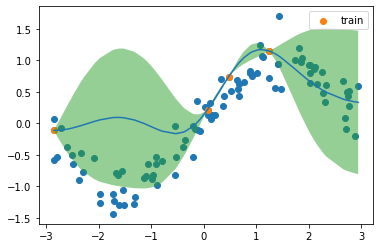

In [4]:
n_train = 4

X_train, _, y_train, _ = train_test_split(X, y, train_size=n_train, random_state=4)

model = GP(X_train, y_train)

key = jax.random.PRNGKey(0)
params = model.optimize(key)

pred_mean, pred_var = model.predict(params, X)
pred_scale = pred_var**0.5

fig, ax = plt.subplots()

ax.scatter(X, y)
ax.scatter(X_train, y_train, label='train')
ax.plot(X, pred_mean)
ax.fill_between(X.ravel(), pred_mean-2*pred_scale, pred_mean+2*pred_scale, alpha=0.5)
ax.legend();

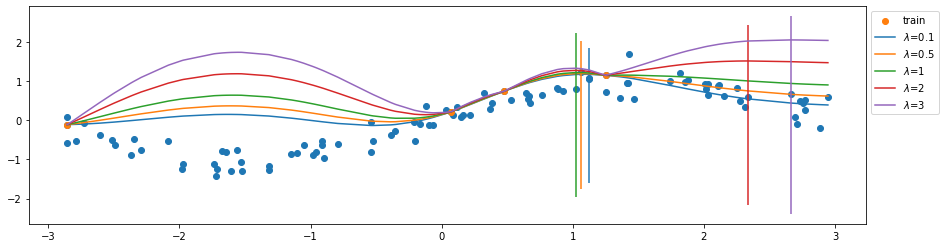

In [5]:
plt.figure(figsize=(15,4))
plt.scatter(X, y)
plt.scatter(X_train, y_train, label='train')

for lmd in [0.1, 0.5, 1, 2, 3]:
    ucb = pred_mean + lmd * pred_scale
    obj = plt.plot(X, ucb, label="$\lambda$="+str(lmd))
    plt.vlines(X[jnp.argmax(ucb)], *plt.ylim(), color=obj[0].get_color())
plt.legend(bbox_to_anchor=(1, 1));

Perform BO

In [6]:
lmd = 1.0
iters = 10

X_train, X_pool, y_train, y_pool = train_test_split(X, y, train_size=n_train, random_state=4)

def ucb_fn(pred_mean, pred_scale):
    return pred_mean + lmd * pred_scale

def do_bo(acq_fn, kwargs):
    global X_train, X_pool, y_train, y_pool
    acq = acq_fn(pred_mean, pred_scale, **kwargs)
    
    buffers = {"X_train": X_train.copy(), "X_pool": X_pool.copy(), 
               "y_train": y_train.copy(), "y_pool": y_pool.copy(), 
              "pred_mean": pred_mean, "pred_scale": pred_scale, "acq": acq}
    
    idx = jnp.argmax(acq)
    X_train = jnp.concatenate([X_train, X_pool[idx:idx+1]], axis=0)
    y_train = jnp.concatenate([y_train, y_pool[idx:idx+1]], axis=0)
    
    X_pool = jnp.delete(X_pool, idx, axis=0)
    y_pool = jnp.delete(y_pool, idx, axis=0)
    history.append(buffers)

history = []
for iter in tqdm(range(iters)):
    model = GP(X_train, y_train)
    params = model.optimize(jax.random.PRNGKey(iter))
    pred_mean, pred_var = model.predict(params, X_pool)
    pred_scale = pred_var**0.5
    do_bo(ucb_fn, {})

100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


In [7]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

def update(i):
    ax[0].cla(), ax[1].cla()
    ax[0].scatter(X, y, alpha=0.4)
    ax[0].scatter(history[i]["X_train"][:-1], history[i]["y_train"][:-1], label="train")
    ax[0].scatter(history[i]["X_train"][-1], history[i]["y_train"][-1], label="selected", marker='x', s=100, c='k')
    ax[0].legend()
    
    idx = jnp.argsort(history[i]["X_pool"].squeeze())

    ax[1].plot(history[i]["X_pool"].squeeze()[idx], history[i]['acq'].squeeze()[idx])
    
anim = FuncAnimation(fig, update, range(len(history)))
plt.close()
anim

### Probability of Improvement (PI)

$$
\text{PI}(x) = 1 - \Phi(z_0) = \Phi(-z_0) = \Phi\left(\frac{\mu(x)-f(x^\star)}{\sigma(x)}\right)
$$

In [8]:
def pi_fn(pred_mean, pred_scale, best_value):
    return jax.scipy.stats.norm.cdf((pred_mean - best_value)/pred_scale)

In [9]:
n_train = 4
X_train, X_pool, y_train, y_pool = train_test_split(X, y, train_size=n_train, random_state=4)
model = GP(X_train, y_train)

key = jax.random.PRNGKey(0)
params = model.optimize(key)

pred_mean, pred_var = model.predict(params, X)
pred_scale = pred_var**0.5

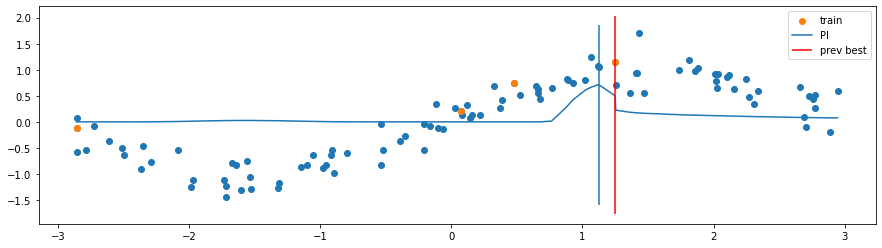

In [10]:
plt.figure(figsize=(15,4))
plt.scatter(X, y)
plt.scatter(X_train, y_train, label='train')

best_value = jnp.max(y_train)
best_idx = jnp.argmax(y_train)

pi = pi_fn(pred_mean, pred_scale, best_value)
obj = plt.plot(X, pi, label="PI")
plt.vlines(X[jnp.argmax(pi)], *plt.ylim(), color=obj[0].get_color())
plt.vlines(X_train[best_idx], *plt.ylim(), label='prev best', color='r')
plt.legend(bbox_to_anchor=(1, 1));

In [11]:
iters = 15
history = []

for iter in tqdm(range(iters)):
    model = GP(X_train, y_train)
    params = model.optimize(jax.random.PRNGKey(iter))
    pred_mean, pred_var = model.predict(params, X_pool)
    pred_scale = pred_var**0.5
    kwargs = {"best_value": jnp.max(y_train)}
    do_bo(pi_fn, kwargs)

100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


In [12]:
animate(X, y, history)

### Expected Improvement

$$
\text{EI}(x)\equiv\mathbb{E}\left[I(x)\right] = \int_{-\infty}^{\infty} I(x)\varphi(z) \mathop{\mathrm{d}z}\\
$$

\begin{aligned}
\text{EI}(x)
&=\int_{z_0}^{\infty} \max(f(x)-f(x^\star),0) \varphi(z)\mathop{\mathrm{d}z} =
\int_{z_0}^{\infty} \left(\mu+\sigma z - f(x^\star)\right)\varphi(z) \mathop{\mathrm{d}z}\\
&= \int_{z_0}^{\infty} \left(\mu - f(x^\star) \right)\varphi(z)\mathop{\mathrm{d}z} +
\int_{z_0}^{\infty} \sigma z \frac{1}{\sqrt{2\pi}}e^{-z^2/2}\mathop{\mathrm{d}z} \\\\
&=\left(\mu- f(x^\star)\right) \underbrace{\int_{z_0}^{\infty}\varphi(z)\mathop{\mathrm{d}z}}_{1-\Phi(z_0)\equiv 1-\text{CDF}(z_0)} + \frac{\sigma}{\sqrt{2\pi}}\int_{z_0}^{\infty}  z e^{-z^2/2}\mathop{\mathrm{d}z}\\
&=\left(\mu- f(x^\star)\right) (1-\Phi(z_0)) - \frac{\sigma}{\sqrt{2\pi}}\int_{z_0}^{\infty}  \left(e^{-z^2/2}\right)' \mathop{\mathrm{d}z}\\
&=\left(\mu- f(x^\star)\right) (1-\Phi(z_0)) - \frac{\sigma}{\sqrt{2\pi}} \left[e^{-z^2/2}\right]_{z_0}^{\infty}\\
&=\left(\mu- f(x^\star)\right) \underbrace{(1-\Phi(z_0))}_{\Phi(-z_0)} + \sigma \varphi(z_0) \\
&=\left(\mu- f(x^\star)\right) \Phi\left(\frac{\mu-f(x^\star)}{\sigma}\right) + \sigma \varphi\left(\frac{\mu - f(x^\star)}{\sigma}\right)
\end{aligned}

In [13]:
def ei_fn(pred_mean, pred_scale, best_value):
    mu_bar = pred_mean - best_value
    first_term = mu_bar*jax.scipy.stats.norm.cdf(mu_bar/pred_scale)
    second_term = pred_scale*jax.scipy.stats.norm.pdf(mu_bar/pred_scale)
    return first_term + second_term

In [14]:
n_train = 4
X_train, X_pool, y_train, y_pool = train_test_split(X, y, train_size=n_train, random_state=4)
model = GP(X_train, y_train)

key = jax.random.PRNGKey(0)
params = model.optimize(key)

pred_mean, pred_var = model.predict(params, X)
pred_scale = pred_var**0.5

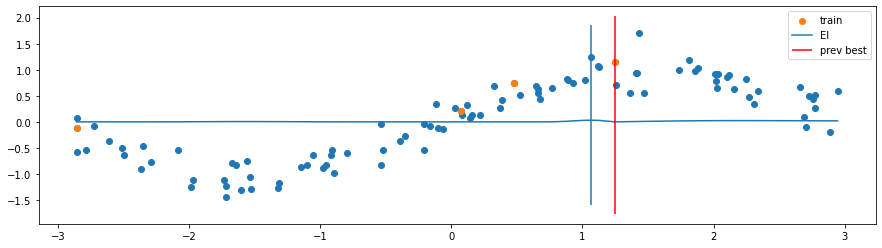

In [15]:
plt.figure(figsize=(15,4))
plt.scatter(X, y)
plt.scatter(X_train, y_train, label='train')

best_value = jnp.max(y_train)
best_idx = jnp.argmax(y_train)

ei = ei_fn(pred_mean, pred_scale, best_value)
obj = plt.plot(X, ei, label="EI")
plt.vlines(X[jnp.argmax(ei)], *plt.ylim(), color=obj[0].get_color())
plt.vlines(X_train[best_idx], *plt.ylim(), label='prev best', color='r')
plt.legend(bbox_to_anchor=(1, 1));

In [16]:
iters = 15
history = []

for iter in tqdm(range(iters)):
    model = GP(X_train, y_train)
    params = model.optimize(jax.random.PRNGKey(iter))
    pred_mean, pred_var = model.predict(params, X_pool)
    pred_scale = pred_var**0.5
    kwargs = {"best_value": jnp.max(y_train)}
    do_bo(ei_fn, kwargs)

100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


In [17]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

def update(i):
    ax[0].cla(), ax[1].cla()
    ax[0].scatter(X, y, alpha=0.4)
    ax[0].scatter(history[i]["X_train"][:-1], history[i]["y_train"][:-1], label="train")
    ax[0].scatter(history[i]["X_train"][-1], history[i]["y_train"][-1], label="selected", marker='x', s=100, c='k')
    ax[0].legend()
    
    idx = jnp.argsort(history[i]["X_pool"].squeeze())

    ax[1].plot(history[i]["X_pool"].squeeze()[idx], history[i]['acq'].squeeze()[idx])
    
anim = FuncAnimation(fig, update, range(len(history)))
plt.close()
anim

## Try to hypertune a Neural Net (Incomplete)

In [18]:
X, y = load_iris(return_X_y=True)
y_one_hot = OneHotEncoder().fit_transform(y[:, None])

X = jnp.array(X)
y = jnp.array(y)
y_one_hot = jnp.array(y_one_hot.todense())

In [19]:
class SimpleMLP(nn.Module):
    n_first_layer: int
    n_second_layer: int

    @nn.compact
    def __call__(self, inputs):
        x = inputs
        x = nn.Dense(self.n_first_layer)(x)
        x = nn.relu(x)
        x = nn.Dense(self.n_second_layer)(x)
        x = nn.relu(x)
        x = nn.Dense(3)(x)
        return x

def loss_fn(params, model, X, y):
    logits = model.apply(params, X)
#     print(logits.shape, y.shape)
    loss = optax.softmax_cross_entropy(logits, y).mean()
    return loss

In [20]:
key = jax.random.PRNGKey(0)
nn_model = SimpleMLP(n_first_layer=5, n_second_layer=2)

init_params = nn_model.init(key, X)
loss_fn(init_params, nn_model, X, y_one_hot)

DeviceArray(3.049982, dtype=float32)

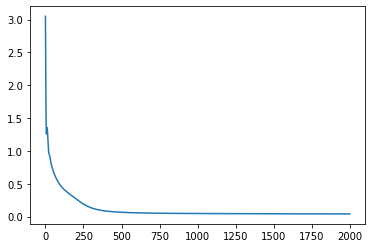

In [21]:
optimizer = optax.adam(learning_rate=0.01)
partial_loss_fn = partial(loss_fn, X=X, y=y_one_hot, model=nn_model)
result = train_fn(partial_loss_fn, init_params, optimizer, num_epochs=2000)
plt.plot(result['loss_history']);

In [22]:
preds = jnp.argmax(nn_model.apply(result['raw_params'], X), axis=1)

accuracy_score(y, preds)

0.9866666666666667

In [23]:
neurons = jnp.arange(2, 12)
N1, N2 = jnp.meshgrid(neurons, neurons)
combinations = [(x1, x2) for x1, x2 in zip(N1.ravel(), N2.ravel())]
len(combinations)

100

In [24]:
key = jax.random.PRNGKey(0)
n_restarts = 10

def evaluate_nn(n1, n2):
    nn_model = SimpleMLP(jnp.array(n1, dtype=jnp.int32), jnp.array(n2, dtype=jnp.int32))
    keys = jax.random.split(key, num=n_restarts)
    init_params = jax.vmap(nn_model.init, in_axes=(0, None))(keys, X)
    partial_loss_fn = partial(loss_fn, X=X, y=y_one_hot, model=nn_model)
    partial_train_fn = partial(train_fn, loss_fn=partial_loss_fn, optimizer=optimizer, num_epochs=50)
    result = jax.vmap(partial_train_fn)(init_raw_params=init_params)
    
    pred_proba = jax.vmap(nn_model.apply, in_axes=(0, None))(result['raw_params'], X)
    
    accuracy_list = jax.vmap(lambda pred, true: (true==jnp.argmax(pred, axis=1)).mean(), in_axes=(0, None))(pred_proba, y)
    return max(accuracy_list)

accuracy = []
for n1, n2 in tqdm(combinations):
    accuracy.append(evaluate_nn(n1, n2))

100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


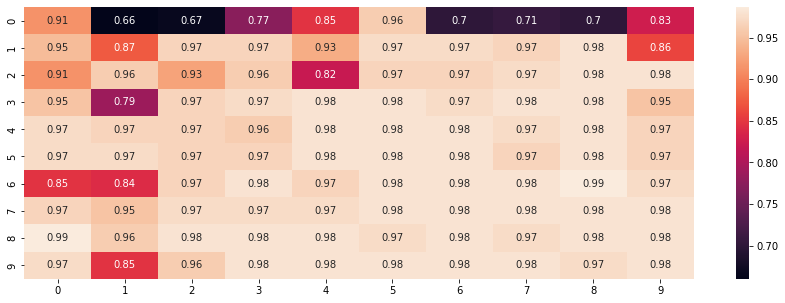

In [25]:
accuracy_grid = jnp.array(accuracy).reshape(N1.shape[0], N1.shape[0])

# plt.contourf(N1, N2, accuracy_grid)
# plt.colorbar();

plt.figure(figsize=(15,5))
sns.heatmap(accuracy_grid, annot=True);